<a href="https://colab.research.google.com/github/AtSourav/AE-n-VAE-with-CB-loss-on-stl10/blob/main/AE_stl10_CBloss_HeNormal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow import math
import tensorflow_datasets as tfds
from keras import losses
from keras import layers
from keras import utils
from keras import backend as K
from keras import initializers

import os
import random
import matplotlib.pyplot as plt

In [13]:
img_ht = 48
img_wd = 48

input_size = (img_ht,img_wd,3)
latent_dim = 512
batch_size = 512

#initializer = initializers.GlorotNormal()
initializer = initializers.HeNormal(seed=123)

In [3]:
ds = tfds.load('stl10', split='test')

In [4]:
ds2 = tfds.load('stl10', split='train')

In [5]:
ds3 = tfds.load('stl10', split='unlabelled[:3%]')

In [6]:
ds_to_np = list(ds.as_numpy_iterator())+list(ds2.as_numpy_iterator()) +list(ds3.as_numpy_iterator())

In [7]:
print(set(tuple(x.keys()) for x in ds_to_np))                # we converted the list of keys into a tuple since we wanted to use set() for duplicate removal
                                                             # set() only works on hashable objects like strings, numbers, and tuples,
                                                             # and not on mutables like dicts and strings

print(set(x['label'] for x in ds_to_np))
print(set(type(x['image']) for x in ds_to_np))
print(set(x['image'].shape for x in ds_to_np))
print(len(ds_to_np))

{('image', 'label')}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, -1}
{<class 'numpy.ndarray'>}
{(96, 96, 3)}
16000


ds_to_np is a list of dictionaries where the key:value pairs are the 'image':img_ndarray, 'label'=-1. We want to collect all these arrays and form a tensor/array. There are 100k images. We'll use 50k of them in the training set, 25k for validation, and 25k for the test set.

In [8]:
random.seed(100)
random.shuffle(ds_to_np)                                    # random permutation in place
img_train = np.array([x['image'] for x in ds_to_np[:15000]])
img_valid = np.array([x['image'] for x in ds_to_np[15000:]])
#img_test = np.array([x['image'] for x in ds_to_np[13000:]])

img_train = img_train/255
img_valid = img_valid/255
#img_test = img_test/255

In [9]:
print(img_train.shape)

(15000, 96, 96, 3)


In [10]:
img_train = layers.Resizing(img_ht, img_wd, interpolation="bilinear")(img_train)
print(img_train.shape)

img_valid = layers.Resizing(img_ht, img_wd, interpolation="bilinear")(img_valid)
print(img_valid.shape)

#img_test = layers.Resizing(img_ht, img_wd, interpolation="bilinear")(img_test)
#print(img_valid.shape)

(15000, 48, 48, 3)
(1000, 48, 48, 3)


In [14]:
encoder_input = keras.Input(shape=input_size)

x = layers.Conv2D(64, 3, padding="valid", kernel_initializer=initializer)(encoder_input)
x = layers.ReLU()(x)

x = layers.Conv2D(64, 3, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid")(x)

x = layers.Conv2D(128, 3, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(128, 3, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(256, 3, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(256, 3, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(256, 3, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(256, 1, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid")(x)
x = layers.ReLU()(x)


x = layers.Conv2D(512, 3, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(512, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(512, 1, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.MaxPooling2D(pool_size=(2, 2), strides=1, padding="valid")(x)

x = layers.Flatten()(x)

x = layers.Dense(2*latent_dim)(x)
x = layers.ReLU()(x)


z = layers.Dense(latent_dim, name="z")(x)

encoder = keras.Model(encoder_input, z, name='encoder')
encoder.summary()



Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 46, 46, 64)        1792      
                                                                 
 re_lu_14 (ReLU)             (None, 46, 46, 64)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 44, 44, 64)        36928     
                                                                 
 re_lu_15 (ReLU)             (None, 44, 44, 64)        0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 22, 22, 64)        0         
 g2D)                                                            
                                                           

In [15]:
latent_input = keras.Input(shape=(latent_dim,))

x = layers.Dense(4*latent_dim)(latent_input)
x = layers.ReLU()(x)

x = layers.Reshape((2,2,512))(x)

x = layers.Conv2DTranspose(512, 1, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(512, 3, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(256, 1, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(256, 3, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(256, 3, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(128, 3, strides=2, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(128, 3, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(128, 3, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(64, 3, strides=2, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(64, 3, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(64, 3, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

decoder_output = layers.Conv2DTranspose(3, 2, activation='sigmoid', padding='valid', kernel_initializer=initializer)(x)

decoder = keras.Model(latent_input, decoder_output, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 512)]             0         
                                                                 
 dense_3 (Dense)             (None, 2048)              1050624   
                                                                 
 re_lu_27 (ReLU)             (None, 2048)              0         
                                                                 
 reshape_1 (Reshape)         (None, 2, 2, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 2, 2, 512)         262656    
 anspose)                                                        
                                                                 
 re_lu_28 (ReLU)             (None, 2, 2, 512)         0         
                                                           

In [16]:
decoder_out = decoder(encoder(encoder_input))
VAE = keras.Model(encoder_input, decoder_out, name='VAE')

VAE.summary()

Model: "VAE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 encoder (Functional)        (None, 512)               6916160   
                                                                 
 decoder (Functional)        (None, 48, 48, 3)         5723203   
                                                                 
Total params: 12639363 (48.22 MB)
Trainable params: 12639363 (48.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [28]:
K.clear_session()

In [17]:
l_cutoff = 0.495
u_cutoff = 0.505

def norm_CB(z):

    gate = math.logical_and(math.greater(z,l_cutoff), math.greater(u_cutoff,z))

    #z = tf.clip_by_value(z, clip_value_min = K.epsilon(), clip_value_max = 1 - K.epsilon())
    z_reg = tf.where(gate, l_cutoff, z)

    norm_reg = (2*math.atanh(1 - 2*z_reg))/(1 - 2*z_reg)
    norm_taylor = 2.0 + (8.0/3.0)*math.pow(z-0.5,2) + (32.0/5.0)*math.pow(z-0.5,4)  +  (128.0/7.0)*math.pow(z-0.5,6)


    norm = tf.where(gate, norm_taylor, norm_reg)

    return norm

def CB_logloss(true, pred):
  true = layers.Flatten()(true)
  pred = layers.Flatten()(pred)
  bce = losses.binary_crossentropy(true,pred)

  corrected_loss_tensor = bce + tf.reduce_mean(math.log(norm_CB(pred)), axis=-1 )


  return tf.reduce_mean(corrected_loss_tensor)



In [18]:
#lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, decay_steps=100, decay_rate=0.98)
optim = keras.optimizers.Adam(learning_rate = 0.001)                  # clipnorm=2.0
VAE.compile(optimizer=optim,loss=CB_logloss)

In [19]:
history = VAE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=20, steps_per_epoch=None)

Epoch 1/20
30/30 [==============================] - 63s 880ms/step - loss: 1.3830 - val_loss: 1.3790
Epoch 2/20
30/30 [==============================] - 16s 536ms/step - loss: 1.3741 - val_loss: 1.3730
Epoch 3/20
30/30 [==============================] - 16s 538ms/step - loss: 1.3678 - val_loss: 1.3635
Epoch 4/20
30/30 [==============================] - 16s 532ms/step - loss: 1.3672 - val_loss: 1.3744
Epoch 5/20
30/30 [==============================] - 16s 534ms/step - loss: 1.3655 - val_loss: 1.3615
Epoch 6/20
30/30 [==============================] - 16s 544ms/step - loss: 1.3574 - val_loss: 1.3521
Epoch 7/20
30/30 [==============================] - 17s 555ms/step - loss: 1.3542 - val_loss: 1.3563
Epoch 8/20
30/30 [==============================] - 17s 569ms/step - loss: 1.3507 - val_loss: 1.3457
Epoch 9/20
30/30 [==============================] - 17s 551ms/step - loss: 1.3482 - val_loss: 1.3487
Epoch 10/20
30/30 [==============================] - 16s 545ms/step - loss: 1.3455 - val_lo

In [20]:
optim = keras.optimizers.Adam(learning_rate = 0.00075)                  # clipnorm=2.0
VAE.compile(optimizer=optim,loss=CB_logloss)
history2 = VAE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=20, steps_per_epoch=None)

Epoch 1/20
30/30 [==============================] - 24s 565ms/step - loss: 1.3758 - val_loss: 1.3457
Epoch 2/20
30/30 [==============================] - 17s 552ms/step - loss: 1.3423 - val_loss: 1.3379
Epoch 3/20
30/30 [==============================] - 17s 564ms/step - loss: 1.3378 - val_loss: 1.3355
Epoch 4/20
30/30 [==============================] - 17s 555ms/step - loss: 1.3358 - val_loss: 1.3344
Epoch 5/20
30/30 [==============================] - 16s 548ms/step - loss: 1.3345 - val_loss: 1.3327
Epoch 6/20
30/30 [==============================] - 17s 557ms/step - loss: 1.3333 - val_loss: 1.3322
Epoch 7/20
30/30 [==============================] - 17s 561ms/step - loss: 1.3328 - val_loss: 1.3313
Epoch 8/20
30/30 [==============================] - 17s 563ms/step - loss: 1.3320 - val_loss: 1.3306
Epoch 9/20
30/30 [==============================] - 17s 554ms/step - loss: 1.3316 - val_loss: 1.3302
Epoch 10/20
30/30 [==============================] - 17s 552ms/step - loss: 1.3312 - val_lo

In [21]:
optim = keras.optimizers.Adam(learning_rate = 0.0005)                  # clipnorm=2.0
VAE.compile(optimizer=optim,loss=CB_logloss)
history3 = VAE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=15, steps_per_epoch=None)

Epoch 1/15
30/30 [==============================] - 25s 563ms/step - loss: 1.3432 - val_loss: 1.3321
Epoch 2/15
30/30 [==============================] - 17s 561ms/step - loss: 1.3305 - val_loss: 1.3281
Epoch 3/15
30/30 [==============================] - 17s 564ms/step - loss: 1.3283 - val_loss: 1.3271
Epoch 4/15
30/30 [==============================] - 17s 553ms/step - loss: 1.3274 - val_loss: 1.3266
Epoch 5/15
30/30 [==============================] - 17s 558ms/step - loss: 1.3269 - val_loss: 1.3263
Epoch 6/15
30/30 [==============================] - 16s 549ms/step - loss: 1.3266 - val_loss: 1.3261
Epoch 7/15
30/30 [==============================] - 17s 554ms/step - loss: 1.3263 - val_loss: 1.3260
Epoch 8/15
30/30 [==============================] - 17s 558ms/step - loss: 1.3261 - val_loss: 1.3259
Epoch 9/15
30/30 [==============================] - 17s 554ms/step - loss: 1.3259 - val_loss: 1.3261
Epoch 10/15
30/30 [==============================] - 17s 553ms/step - loss: 1.3257 - val_lo

In [22]:
optim = keras.optimizers.Adam(learning_rate = 0.00025)                  # clipnorm=2.0
VAE.compile(optimizer=optim,loss=CB_logloss)
history4 = VAE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=15, steps_per_epoch=None)

Epoch 1/15
30/30 [==============================] - 24s 569ms/step - loss: 1.3294 - val_loss: 1.3263
Epoch 2/15
30/30 [==============================] - 17s 565ms/step - loss: 1.3247 - val_loss: 1.3252
Epoch 3/15
30/30 [==============================] - 17s 569ms/step - loss: 1.3237 - val_loss: 1.3250
Epoch 4/15
30/30 [==============================] - 17s 551ms/step - loss: 1.3235 - val_loss: 1.3250
Epoch 5/15
30/30 [==============================] - 16s 549ms/step - loss: 1.3233 - val_loss: 1.3249
Epoch 6/15
30/30 [==============================] - 17s 551ms/step - loss: 1.3231 - val_loss: 1.3249
Epoch 7/15
30/30 [==============================] - 17s 565ms/step - loss: 1.3230 - val_loss: 1.3249
Epoch 8/15
30/30 [==============================] - 17s 556ms/step - loss: 1.3228 - val_loss: 1.3248
Epoch 9/15
30/30 [==============================] - 17s 555ms/step - loss: 1.3226 - val_loss: 1.3249
Epoch 10/15
30/30 [==============================] - 17s 562ms/step - loss: 1.3224 - val_lo

In [28]:
optim = keras.optimizers.Adam(learning_rate = 0.00015)                  # clipnorm=2.0
VAE.compile(optimizer=optim,loss=CB_logloss)
history5 = VAE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=15, steps_per_epoch=None)

Epoch 1/15
30/30 [==============================] - 24s 553ms/step - loss: 1.3233 - val_loss: 1.3246
Epoch 2/15
30/30 [==============================] - 16s 543ms/step - loss: 1.3210 - val_loss: 1.3246
Epoch 3/15
30/30 [==============================] - 17s 565ms/step - loss: 1.3208 - val_loss: 1.3248
Epoch 4/15
30/30 [==============================] - 17s 565ms/step - loss: 1.3206 - val_loss: 1.3247
Epoch 5/15
30/30 [==============================] - 17s 563ms/step - loss: 1.3205 - val_loss: 1.3247
Epoch 6/15
30/30 [==============================] - 16s 550ms/step - loss: 1.3204 - val_loss: 1.3249
Epoch 7/15
30/30 [==============================] - 16s 550ms/step - loss: 1.3203 - val_loss: 1.3248
Epoch 8/15
30/30 [==============================] - 17s 553ms/step - loss: 1.3202 - val_loss: 1.3249
Epoch 9/15
30/30 [==============================] - 17s 557ms/step - loss: 1.3201 - val_loss: 1.3249
Epoch 10/15
30/30 [==============================] - 17s 556ms/step - loss: 1.3200 - val_lo

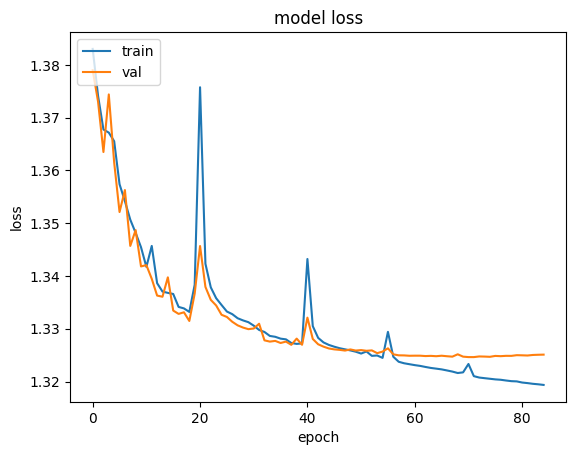

In [29]:
plt.plot(history.history['loss']+history2.history['loss']+history3.history['loss']+history4.history['loss']+history5.history['loss'])
plt.plot(history.history['val_loss']+history2.history['val_loss']+history3.history['val_loss']+history4.history['val_loss']+history5.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [24]:
def plot_reconstruction(set, name,seed_val, epochs):     #name should be either 'training' or 'validation'
  np.random.seed(seed_val)

  tg_indices = np.random.randint(0,set.shape[0],size = 16)
  img_sample = tf.convert_to_tensor(np.array(set)[tg_indices])
  z_sample = encoder(img_sample)
  img_recon = decoder(z_sample)

  recon = plt.figure(figsize=(18,8))    # it's weird that the order of axes in figsize is the opposite to that in add_subplot
  recon.suptitle('Reconstructed images (right) from the ' + name + '-set after ' + str(epochs) + ' epochs: no regularisation in the encoder, decoder, latent_dim = 512', fontweight= 'bold', y=0.93)

  recon.tight_layout()

  for i in range(36):
    recon.add_subplot(4,9,i+1)
    j = int(np.floor(i/9))
    if (i%9) <4:
      img = set[tg_indices[j*4 + (i%9)]]
      plt.imshow(img)
      plt.axis('off')
    elif (i%9)==4:
      img = np.ones((64,64,3))
      plt.imshow(img)
      plt.axis('off')
    else:
      img = img_recon[j*4 + (i%9) - 5]
      plt.imshow(img)
      plt.axis('off')

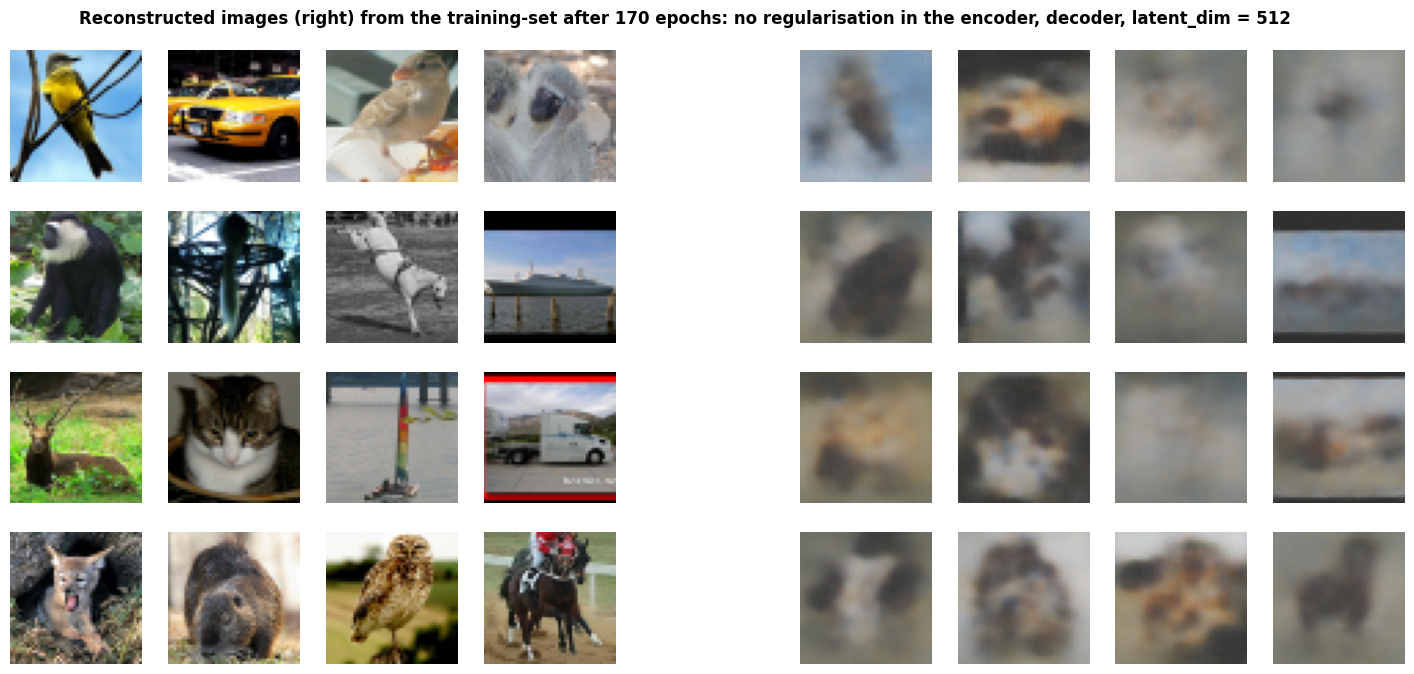

In [30]:
plot_reconstruction(img_train, 'training', 100, 170)

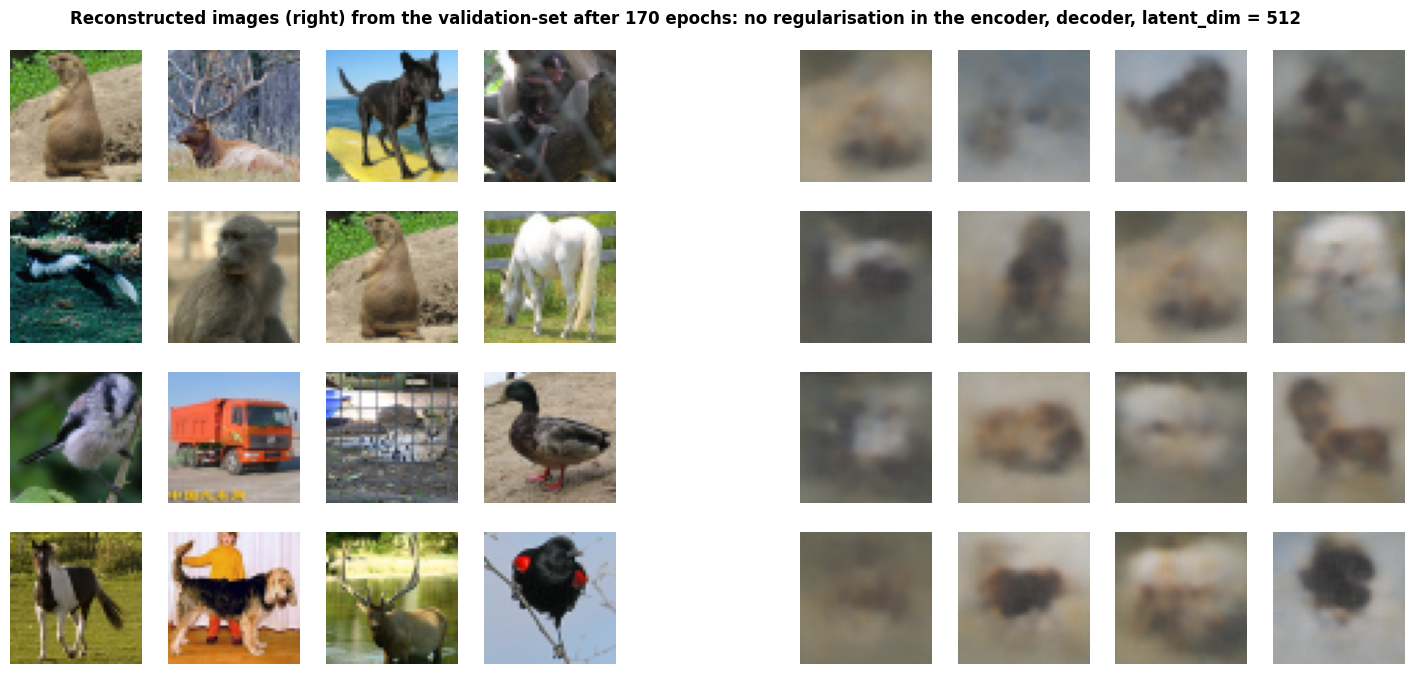

In [32]:
plot_reconstruction(img_valid, 'validation', 105, 170)